# Operator Inference Eigenvalue Stability Analysis

With the Burgers' equation developed in the paper by [H. Aref and P. K. Daripa](https://epubs.siam.org/doi/10.1137/0905060) we check the stability of the inferred model by analyzing its eigenvalues when we do not have ample training data.

## Settings

In [1]:
using DataFrames
using FileIO
using JLD2
using LaTeXStrings
using LinearAlgebra
using Plots
using Random
using SparseArrays
using Statistics
using NaNStatistics

include("../src/model/Burgers.jl")
include("../src/LiftAndLearn.jl")
const LnL = LiftAndLearn
;

Main.LiftAndLearn

In [2]:
# First order Burger's equation setup
burger = Burgers(
    [0.0, 1.0], [0.0, 1.0], [0.15, 1.0],
    2^(-7), 1e-4, 1, "periodic"
)
burger.IC = sin.(2 * pi * burger.x)
# ic_a = [0.95, 1.0, 1.05]
ic_a = 1.0
num_ICs = length(ic_a)

# Minimum and maximum dimensions
rmin = 1
rmax = 10

burger_system = LnL.sys_struct(
    is_lin=true,
    is_quad=true,
)
burger_vars = LnL.vars(
    N=1,
)
burger_data = LnL.data(
    Δt=1e-4,
    DS=100,
)
burger_optim = LnL.opt_settings(
    verbose=true,
    initial_guess=false,
    max_iter=500,
    reproject=false,
    SIGE=false,
)

# Downsampling rate
DS = burger_data.DS

Tdim_ds = size(1:DS:burger.Tdim, 1)  # downsampled time dimension
;

In [3]:
@info "Generate testing data"
## Create testing data
A_fom, F_fom = burger.generateEPmatrix(burger, burger.μs[1])
Xtest = burger.semiImplicitEuler(A_fom, F_fom, burger.t, burger.IC)
op_burger = LnL.operators(A=A_fom, F=F_fom)


@info "Generate training data for inferred dynamical models"
## training data for inferred dynamical models
Xall = Vector{Matrix{Float64}}(undef, num_ICs)
Xdotall = Vector{Matrix{Float64}}(undef, num_ICs)
for j in 1:num_ICs
    states = burger.semiImplicitEuler(A_fom, F_fom, burger.t, ic_a[j] * burger.IC)
    tmp = states[:, 2:end]
    Xall[j] = tmp[:, 1:DS:end]  # downsample data
    tmp = (states[:, 2:end] - states[:, 1:end-1]) / burger.Δt
    Xdotall[j] = tmp[:, 1:DS:end]  # downsample data
end
X = reduce(hcat, Xall)
R = reduce(hcat, Xdotall)
# XR = hcat(X, R)

# compute the POD basis from the training data
X_svd = svd(X)
Vrmax = X_svd.U[:, 1:rmax]

# compute the Difference Quotient (DQ) operator
# R_svd = svd(R)
# DQrmax = R_svd.U[:, 1:rmax]
;

┌ Info: Generate testing data
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_ep-burgers_OpInf.ipynb:1


┌ Info: Generate training data for inferred dynamical models
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_ep-burgers_OpInf.ipynb:8


In [4]:
@info "Compute the intrusive model"
options = LnL.LS_options(
    system=burger_system,
    vars=burger_vars,
    data=burger_data,
    optim=burger_optim,
    λ = 0.0,                  # Tikhonov regularization parameter
    pinv_tol = 1e-12,          # tolerance for pseudo-inverse
)

# Compute the values for the intrusive model from the basis of the training data
op_int = LnL.intrusiveMR(op_burger, Vrmax, options)
;

┌ Info: Compute the intrusive model
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_ep-burgers_OpInf.ipynb:1


In [5]:
@info "Compute the Least-Squares model"
if options.optim.reproject == false
    op_LS = LnL.inferOp(X, zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vrmax, R, options)
else
    op_LS = LnL.inferOp(X, zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vrmax, op_burger, options)
end
;

┌ Info: Compute the Least-Squares model
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_ep-burgers_OpInf.ipynb:1
┌ Warning: Rank difficient, rank = 20, tol = 1.8222446875092428e-13.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\learn.jl:89


In [6]:
@info "Compute the EPHEC model"
options = LnL.EPHEC_options(
    system=burger_system,
    vars=burger_vars,
    data=burger_data,
    optim=burger_optim,
    λ_lin = 0.0,
    λ_quad = 0.0,
)


# Compute the inferred operators from the training data
# if options.optim.reproject == false
#     options.optim.initial_guess = true
#     op_ephec = LnL.inferOp(X, zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vrmax, Vrmax' * R, options) 
# else
#     op_ephec = LnL.inferOp(X, zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vrmax, op_burger, options) 
# end


options.optim.SIGE = true
op_ephec = Vector{LnL.operators}(undef, rmax)
options.optim.initial_guess = false
op_tmp = LnL.inferOp(X, zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vrmax[:,1:rmin], R, options)
op_ephec[rmin] = op_tmp
for j in rmin+1:rmax
    options.optim.initial_guess = true
    op_tmp = LnL.inferOp(X, zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vrmax[:,1:j], R, options, LnL.operators(A=op_tmp.A, F=op_tmp.F))
    op_ephec[j] = op_tmp
end


# function extrapolate_op_1(op:: LnL.operators, j::Int64)
#     Anext = [op_tmp.A zeros(j, 1); zeros(1, j+1)]
#     Fnext = Matrix(LnL.insert2F(op_tmp.F, j+1))
#     return Anext, Fnext
# end

# function extrapolate_op_4(op:: LnL.operators, j::Int64)
#     ub = abs(op.A[j,j])
#     new_row = 2*ub*rand(1, j) .- ub
#     new_diag = -ub * (1 + rand())
#     Anext = [op.A new_row'; new_row new_diag]
#     Fnext = Matrix(LnL.insert2F(op.F, j+1))
#     return Anext, Fnext
# end


# TODO: (Method 2) Use DQ to update
# Atilde = DQrmax[:,1:j] * op_tmp.A * DQrmax[:,1:j]'  # reconstruct full state matrix
# Ftilde = DQrmax[:,1:j] * op_tmp.F * LnL.elimat(j) * LnL.nommat(j) * kron(DQrmax[:,1:j]', DQrmax[:,1:j]') * LnL.elimat(burger.Xdim)' 
# op_tmp.A = DQrmax[:,1:j+1]' * Atilde * DQrmax[:,1:j+1]
# op_tmp.F = DQrmax[:,1:j+1]' * Ftilde * LnL.elimat(burger.Xdim) * kron(DQrmax[:,1:j+1], DQrmax[:,1:j+1]) * LnL.dupmat(j+1)

;

┌ Info: Compute the EPHEC model
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_ep-burgers_OpInf.ipynb:1


┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:24
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:139



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        1
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality co

┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:141
┌ Info: [EP-OpInf Results]
│ Constraint           = Energy-Preserving Hard Equality Constraint
│ Linear Regulation    = 0.0
│ Quadratic Regulation = 0.0
│ Warm Start           = false
│ order                = 1
│ solve time           = 0.11800003051757812
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 20166.168717732457
│ objective_value      = 8.676314241391083
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:143


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        6
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       30

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.5654660e+03 1.37e-30 5.02e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:163
┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:24
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:139
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:141
┌ Info: [EP-OpInf Results]
│ Constraint           = Energy-Preserving Hard Equality Constraint
│ Linear Regulation    = 0.0
│ Quadratic Regulation = 0.0
│ Warm Start           = true
│ order                = 2
│ solve time           = 0.0009999275207519531
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 21722.9584387456
│ objective_value      = 0.03286695527678404
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       75
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1050

Total number of variables............................:      100
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       35
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.6179155e-04 8.88e-16 6.75e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:139
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:141
┌ Info: [EP-OpInf Results]
│ Constraint           = Energy-Preserving Hard Equality Constraint
│ Linear Regulation    = 0.0
│ Quadratic Regulation = 0.0
│ Warm Start           = true
│ order                = 5
│ solve time           = 0.002000093460083008
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 21734.387193387116
│ objective_value      = 7.345287492076964e-6
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:143
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:163
┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimiz

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      196
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4410

Total number of variables............................:      245
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       84
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.3514671e-06 2.91e-11 2.31e-03  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:24
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:139
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:141
┌ Info: [EP-OpInf Results]
│ Constraint           = Energy-Preserving Hard Equality Constraint
│ Linear Regulation    = 0.0
│ Quadratic Regulation = 0.0
│ Warm Start           = true
│ order                = 7
│ solve time           = 0.006999969482421875
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 21734.387193871797
│ objective_value      = 7.344468482084926e-6
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:143
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimize

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      288
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     7920

Total number of variables............................:      352
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      120
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.3444685e-06 9.09e-13 1.15e-04  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:139
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:141
┌ Info: [EP-OpInf Results]
│ Constraint           = Energy-Preserving Hard Equality Constraint
│ Linear Regulation    = 0.0
│ Quadratic Regulation = 0.0
│ Warm Start           = true
│ order                = 8
│ solve time           = 0.023000001907348633
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 21734.3871938718
│ objective_value      = 7.346101666400802e-6
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:143
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:163
┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      405
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    13365

Total number of variables............................:      486
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      165
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.3461017e-06 9.09e-13 5.11e-06  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:139
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:141
┌ Info: [EP-OpInf Results]
│ Constraint           = Energy-Preserving Hard Equality Constraint
│ Linear Regulation    = 0.0
│ Quadratic Regulation = 0.0
│ Warm Start           = true
│ order                = 9
│ solve time           = 0.002000093460083008
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 21734.3871938718
│ objective_value      = 7.345974702870498e-6
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:143
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:163
┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      550
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    21450

Total number of variables............................:      650
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      220
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  7.3459747e-06 1.82e-12 2.33e-07  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:139
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:141
┌ Info: [EP-OpInf Results]
│ Constraint           = Energy-Preserving Hard Equality Constraint
│ Linear Regulation    = 0.0
│ Quadratic Regulation = 0.0
│ Warm Start           = true
│ order                = 10
│ solve time           = 0.039999961853027344
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 21734.3871938718
│ objective_value      = 7.3445752533500074e-6
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:143
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:163


In [7]:
@info "Compute the EPSIC OpInf."

options = LnL.EPSIC_options(
    system=burger_system,
    vars=burger_vars,
    data=burger_data,
    optim=burger_optim,
    λ_lin = 0.0,
    ϵ=1e-3,
)


if options.optim.reproject == false
    op_epsic = LnL.inferOp(X, zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vrmax, Vrmax' * R, options)
else
    op_epsic = LnL.inferOp(X, zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vrmax, op_burger, options)
end

# options.optim.SIGE = true
# op_epsic = Vector{LnL.operators}(undef, rmax)
# options.optim.initial_guess = false
# op_tmp = LnL.inferOp(X, zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vrmax[:,1:rmin], Vrmax[:,1:rmin]' * R, options)
# op_epsic[rmin] = op_tmp
# for j in rmin+1:rmax
#     options.optim.initial_guess = true
#     op_tmp = LnL.inferOp(X, zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vrmax[:,1:j], Vrmax[:,1:j]' * R, options, LnL.operators(A=op_tmp.A, F=op_tmp.F))
#     op_epsic[j] = op_tmp
# end

;

┌ Info: Compute the EPSIC OpInf.
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_ep-burgers_OpInf.ipynb:1


┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:191
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:313
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:315


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1100
Number of nonzeros in Lagrangian Hessian.............:    21450

Total number of variables............................:      650
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      440
        inequality constraints with only lower bounds:      220
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      220

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1734387e+04 0.00e+00 1.83e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

┌ Info: [EP-OpInf Results]
│ Constraint           = Energy-Preserving Soft Inequality Constraint
│ Linear Regulation    = 0.0
│ Quadratic Regulation = 0
│ Warm Start           = true
│ order                = 10
│ solve time           = 0.22899985313415527
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 21734.3870463577
│ objective_value      = 4.3568852946981965e-6
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:317
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:337


In [8]:
@info "Compute the EPUC OpInf."

options = LnL.EPUC_options(
    system=burger_system,
    vars=burger_vars,
    data=burger_data,
    optim=burger_optim,
    α=1e5,
)


if options.optim.reproject == false
    op_epuc = LnL.inferOp(X, zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vrmax, Vrmax' * R, options)
else
    op_epuc = LnL.inferOp(X, zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vrmax, op_burger, options)
end

# options.optim.SIGE = true
# op_epuc = Vector{LnL.operators}(undef, rmax)
# options.optim.initial_guess = false
# op_tmp = LnL.inferOp(X, zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vrmax[:,1:rmin], Vrmax[:,1:rmin]' * R, options)
# op_epuc[rmin] = op_tmp
# for j in rmin+1:rmax
#     options.optim.initial_guess = true
#     op_tmp = LnL.inferOp(X, zeros(Tdim_ds,1), zeros(Tdim_ds,1), Vrmax[:,1:j], Vrmax[:,1:j]' * R, options, LnL.operators(A=op_tmp.A, F=op_tmp.F))
#     op_epuc[j] = op_tmp
# end

;

┌ Info: Compute the EPUC OpInf.
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_ep-burgers_OpInf.ipynb:1


┌ Info: Initialize optimization model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:365
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:473
┌ Info: Optimize model.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:475


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    21900

Total number of variables............................:      650
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.1734387e+04 0.00e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

┌ Info: [EP-OpInf Results]
│ Constraint           = Energy-Preserving Unconstrained
│ EP Weight            = 100000.0
│ Linear Regulation    = 0
│ Quadratic Regulation = 0
│ Warm Start           = true
│ order                = 10
│ solve time           = 0.14600014686584473
│ termination_status   = LOCALLY_SOLVED
│ primal_status        = FEASIBLE_POINT
│ dual_state           = FEASIBLE_POINT
│ dual objective value = 21734.3871938718
│ objective_value      = 1.569107746975435e-5
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:477
┌ Info: Done.
└ @ Main.LiftAndLearn c:\Users\tkoike3\Code\LiftAndLearn.jl\src\optimizer\EP_Optimize.jl:498


In [12]:
@info "Compute the errors"

# Values to store 
proj_err = Vector{Float64}()
intru_state_err = Vector{Float64}()
ls_state_err = Vector{Float64}()
ephec_state_err = Vector{Float64}()
epsic_state_err = Vector{Float64}()
epuc_state_err = Vector{Float64}()
intru_cr = Vector{Float64}()
ls_cr = Vector{Float64}()
ephec_cr = Vector{Float64}()
epsic_cr = Vector{Float64}()
epuc_cr = Vector{Float64}()

for j = rmin:rmax
    Vr = Vrmax[:, 1:j]  # basis

    # Projection Error
    push!(proj_err, LnL.compProjError(Xtest, Vr))
    
    # Intrusive model
    Fint_extract = LnL.extractF(op_int.F, j)
    Xint = burger.semiImplicitEuler(op_int.A[1:j, 1:j], Fint_extract, burger.t, Vr' * burger.IC)  
    push!(intru_state_err, LnL.compStateError(Xtest, Xint, Vr))
    tmp, _ = LnL.constraintResidual(Fint_extract, j, options.optim.which_quad_term)
    push!(intru_cr, tmp)

    # Least-Squares model
    Fls_extract = LnL.extractF(op_LS.F, j)
    Xls = burger.semiImplicitEuler(op_LS.A[1:j, 1:j], Fls_extract, burger.t, Vr' * burger.IC) 
    push!(ls_state_err, LnL.compStateError(Xtest, Xls, Vr))
    tmp, _ = LnL.constraintResidual(Fls_extract, j, options.optim.which_quad_term)
    push!(ls_cr, tmp)
    
    # Integrate the ephec model
    Fephec_extract = LnL.extractF(op_ephec[10].F, j)
    Xephec = burger.semiImplicitEuler(op_ephec[10].A[1:j, 1:j], Fephec_extract, burger.t, Vr' * burger.IC)  
    push!(ephec_state_err, LnL.compStateError(Xtest, Xephec, Vr))
    tmp, _ = LnL.constraintResidual(Fephec_extract, j, options.optim.which_quad_term)
    push!(ephec_cr, tmp)

    # Xephec = burger.semiImplicitEuler(op_ephec[j].A, op_ephec[j].F, burger.t, Vr' * burger.IC)  
    # push!(ephec_state_err, LnL.compStateError(Xtest, Xephec, Vr))
    # tmp, _ = LnL.constraintResidual(op_ephec[j].F, j, options.optim.which_quad_term)
    # push!(ephec_cr, tmp)


    # Integrate the epsic model
    Fepsic_extract = LnL.extractF(op_epsic.F, j)
    Xepsic = burger.semiImplicitEuler(op_epsic.A[1:j, 1:j], Fepsic_extract, burger.t, Vr' * burger.IC)  
    push!(epsic_state_err, LnL.compStateError(Xtest, Xepsic, Vr))
    tmp, _ = LnL.constraintResidual(Fepsic_extract, j, options.optim.which_quad_term)
    push!(epsic_cr, tmp)

    # Xepsic = burger.semiImplicitEuler(op_epsic[j].A, op_epsic[j].F, burger.t, Vr' * burger.IC)  
    # push!(epsic_state_err, LnL.compStateError(Xtest, Xepsic, Vr))
    # tmp, _ = LnL.constraintResidual(op_epsic[j].F, j, options.optim.which_quad_term)
    # push!(epsic_cr, tmp)
    
    # Integrate the epuc model
    Fepuc_extract = LnL.extractF(op_epuc.F, j)
    Xepuc = burger.semiImplicitEuler(op_epuc.A[1:j, 1:j], Fepuc_extract, burger.t, Vr' * burger.IC) 
    push!(epuc_state_err, LnL.compStateError(Xtest, Xepuc, Vr))
    tmp, _  = LnL.constraintResidual(Fepuc_extract, j, options.optim.which_quad_term)
    push!(epuc_cr, tmp)

    # Xepuc = burger.semiImplicitEuler(op_epuc[j].A, op_epuc[j].F, burger.t, Vr' * burger.IC) 
    # push!(epuc_state_err, LnL.compStateError(Xtest, Xepuc, Vr))
    # tmp, _  = LnL.constraintResidual(op_epuc[j].F, j, options.optim.which_quad_term)
    # push!(epuc_cr, tmp)
end

┌ Info: Compute the errors
└ @ Main c:\Users\tkoike3\Code\LiftAndLearn.jl\examples\07_ep-burgers_OpInf.ipynb:1


In [ ]:
show(stdout, "text/plain", op_ephec[10].A)

In [88]:
foo = eigen(op_ephec[10].A)
foo.values

10-element Vector{ComplexF64}:
      -49.93774821565071 + 0.0im
     -24.010675242063975 + 0.0im
        -5.9195597388815 + 0.0im
 -3.0157854131198184e-11 + 0.0im
 -3.5783096780802535e-16 + 0.0im
 -1.9027187804718182e-19 + 0.0im
    1.007290204773926e-8 + 0.0im
      6.6397431141341e-5 + 0.0im
      28560.868333092723 - 68492.89959719218im
      28560.868333092723 + 68492.89959719218im

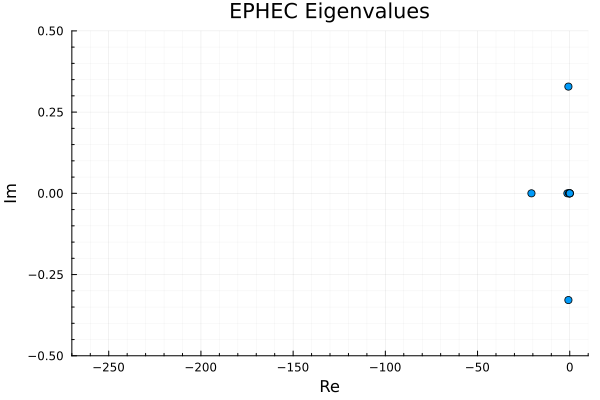

In [81]:
p_ephec_poles = plot()
# for i in 1:10
foo = eigen(op_ephec.A)
#     plot!(p_ephec_poles, real(foo.values), imag(foo.values), seriestype=:scatter, label="r = $i")
plot!(p_ephec_poles, real(foo.values), imag(foo.values), seriestype=:scatter)
# end
plot!(p_ephec_poles, xlabel="Re", ylabel="Im", legend=false, title="EPHEC Eigenvalues")
plot!(p_ephec_poles, majorgrid=true, minorgrid=true, size=(600, 400))
plot!(p_ephec_poles, xlims=(-270, 10), ylims=(-0.5,0.5))

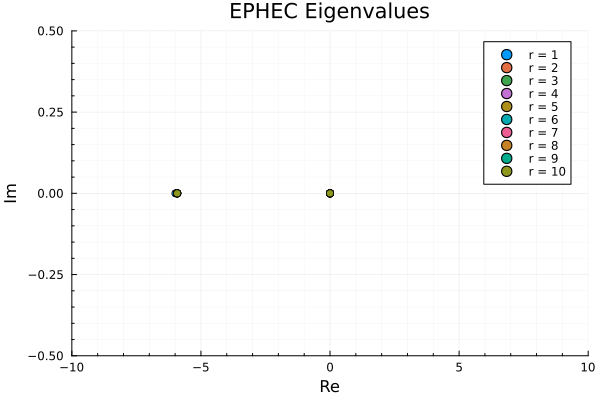

In [83]:
p_ephec_poles = plot()
for i in 1:10
    foo = eigen(op_ephec[i].A)
    plot!(p_ephec_poles, real(foo.values), imag(foo.values), seriestype=:scatter, label="r = $i")
end
plot!(p_ephec_poles, xlabel="Re", ylabel="Im", legend=:topright, title="EPHEC Eigenvalues")
plot!(p_ephec_poles, majorgrid=true, minorgrid=true, size=(600, 400))
plot!(p_ephec_poles, xlims=(-10,10), ylims=(-0.5, 0.5))

In [12]:
show(stdout, "text/plain", op_int.A)

10×10

 Matrix{Float64}:
 -5.99779       -1.18226       0.163114     -0.0140267       0.000953305    -4.79767e-5     2.00364e-6    -9.9219e-8     -4.05399e-9      1.3084e-10
 -1.18226      -24.0553        3.74424      -0.369753        0.0255917      -0.00133261     5.77251e-5    -2.82312e-6    -1.15715e-7      3.82123e-9
  0.163114       3.74424     -54.2486        7.98872        -0.675551        0.0387907     -0.001783       8.78664e-5     3.69061e-6     -1.27038e-7
 -0.0140267     -0.369753      7.98872     -96.43           13.7561         -0.982329       0.0503864     -0.00255678    -0.000113254     4.0519e-6
  0.000953305    0.0255917    -0.675551     13.7561       -150.746          21.3862        -1.50331        0.0819423      0.00385673     -0.000151527
 -4.79767e-5    -0.00133261    0.0387907    -0.982329       21.3862       -216.691         30.4595        -2.1381        -0.113687        0.00498365
  2.00364e-6     5.77251e-5   -0.001783      0.0503864      -1.50331        30.4595     

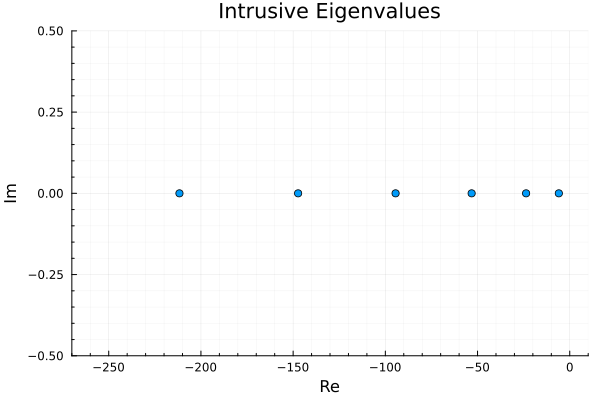

In [61]:
p_int_poles = plot()
foo = eigen(op_int.A)
plot!(p_int_poles, real(foo.values), imag(foo.values), seriestype=:scatter)
plot!(p_int_poles, xlabel="Re", ylabel="Im", title="Intrusive Eigenvalues", legend=false)
plot!(p_int_poles, majorgrid=true, minorgrid=true, size=(600, 400))
plot!(p_int_poles, xlims=(-270, 10),  ylims=(-0.5, 0.5))

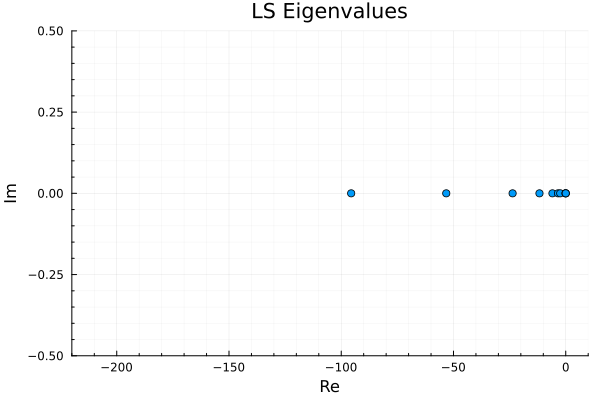

In [62]:
p_ls_poles = plot()
foo = eigen(op_LS.A)
plot!(p_ls_poles, real(foo.values), imag(foo.values), seriestype=:scatter)
plot!(p_ls_poles, xlabel="Re", ylabel="Im", title="LS Eigenvalues", legend=false)
plot!(p_ls_poles, majorgrid=true, minorgrid=true, size=(600, 400))
plot!(p_ls_poles, xlims=(-220, 10),  ylims=(-0.5, 0.5))

In [18]:
show(stdout, "text/plain", op_epsic[10].A)

10×10 Matrix{Float64}:
 -5.998        -1.18551       0.161376      -0.0372506     0.0293373     0.000304309   6.67883e-6    9.4556e-8    -6.41892e-10  -1.39054e-11
 -1.18233     -24.0571        3.76806       -0.313085      0.00984592   -8.085e-5      4.90546e-7   -9.33708e-9    1.10818e-10   9.2174e-13
  0.162563      3.73663     -54.2809         8.00248      -0.0140785     6.24852e-5   -9.917e-7     -5.45875e-8   -7.13093e-10  -1.35935e-12
 -0.0137893    -0.364546      7.89452      -95.7185       -0.116196      0.00116032   -2.39218e-5   -4.93166e-7   -6.49736e-10   2.2805e-11
  0.00375179    0.0732984    -0.599016      -0.730351     -1.17739       0.00178412   -7.31953e-5   -4.74175e-7   -2.18801e-8   -9.44916e-11
  5.99469e-5    0.00116587   -0.00913416    -0.00791855   -0.0208787     0.000587789  -1.07241e-5   -2.9066e-7    -8.82681e-9   -3.65782e-11
  4.69763e-6    9.32528e-5   -0.000791472   -0.000761048  -0.000595402   2.63714e-5   -1.33643e-7   -4.60938e-9    9.91522e-11   3.18

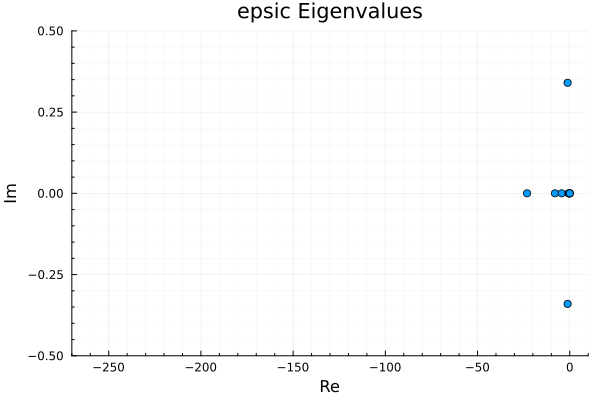

In [82]:
p_epsic_poles = plot()
# for i in 1:10
#     foo = eigen(op_epsic[i].A)
#     plot!(p_epsic_poles, real(foo.values), imag(foo.values), seriestype=:scatter, label="r = $i")
# end
foo = eigen(op_epsic.A)
plot!(p_epsic_poles, real(foo.values), imag(foo.values), seriestype=:scatter)
plot!(p_epsic_poles, xlabel="Re", ylabel="Im", legend=false, title="epsic Eigenvalues")
plot!(p_epsic_poles, majorgrid=true, minorgrid=true, size=(600, 400))
plot!(p_epsic_poles, xlims=(-270, 10),  ylims=(-0.5, 0.5))

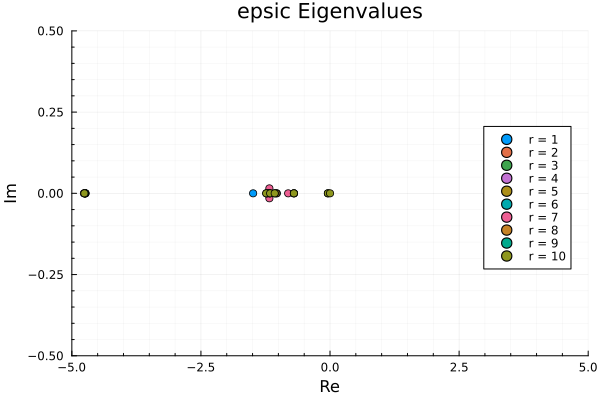

In [57]:
p_epsic_poles = plot()
for i in 1:10
    foo = eigen(op_epsic[i].A)
    plot!(p_epsic_poles, real(foo.values), imag(foo.values), seriestype=:scatter, label="r = $i")
end
plot!(p_epsic_poles, xlabel="Re", ylabel="Im", legend=:right, title="epsic Eigenvalues")
plot!(p_epsic_poles, majorgrid=true, minorgrid=true, size=(600, 400))
plot!(p_epsic_poles, xlims=(-5, 5), ylims=(-0.5, 0.5))

In [20]:
for i in 1:10
    foo = eigen(op_epsic[i].A)
    println("Eigenvalues of A for r = $i is: ", foo.values)
end

Eigenvalues of A for r = 1 is: [-5.986613538372772]
Eigenvalues of A for r = 2 is: [-24.532053862191525, -5.921328560214892]
Eigenvalues of A for r = 3 is: [-54.4591364827273, -23.67310931511697, -5.9205868314404775]
Eigenvalues of A for r = 4 is: [-97.22190553145964, -53.235411236344355, -23.668001522573714, -5.920576191400073]
Eigenvalues of A for r = 5 is: [-97.2160111857552, -53.262474859330474, -23.66809607006129, -5.920575762794014, -1.1473955224437506]
Eigenvalues of A for r = 6 is: [-97.21410978476496, -53.26244228950502, -23.668100075585503, -5.920573726823761, -1.1551926544461175, 0.00017716757652876065]
Eigenvalues of A for r = 7 is: [-97.21210095760796, -53.26227549229082, -23.66809189954166, -5.920573664299058, -1.1616084265613829, 4.992011723132154e-8, 0.00031497496742221534]
Eigenvalues of A for r = 8 is: [-97.21002585299448, -53.26201461401132, -23.668085322357665, -5.920573653724271, -1.1670627202050778, -1.207102177213346e-10, 1.4219755732151102e-7, 0.0004178078208269

In [26]:
show(stdout, "text/plain", op_epuc[10].A)

10×10 Matrix{Float64}:
 -1.53778     -1.3739       0.700974    -0.392131   -0.578036   -2.36571    -4.59177    -3.57993     2.49779     -0.748449
 -1.36864     -6.74349      4.65184     -2.40622    -0.947958   -7.27368    -3.57024    -1.37142     2.79283     -0.892924
  0.712628     4.43217    -15.7834       8.7034     -3.56141    -3.88091    -2.80481     2.73888    -1.15489      0.387191
 -0.356692    -2.35516     12.6571     -32.1983     19.1187     -3.54383     4.58828    -0.892392    0.218164    -0.185184
 -0.282183    -1.40664      1.39972     12.6386    -46.6149      5.59581    -0.973325   -0.0132655  -0.227115     0.197078
 -0.0252561   -0.160759     1.13352     -2.33902     5.41641    -3.02586     0.0134137   0.0492633   0.14233     -0.161269
  0.100378     0.630966    -2.48594      5.02536    -0.832663    0.412776   -1.07037    -0.151403   -0.0279974    0.155129
 -0.155917    -0.836741     2.33334     -1.88176    -0.0145618  -0.252455   -0.120004   -0.899647    0.00579916  -0.

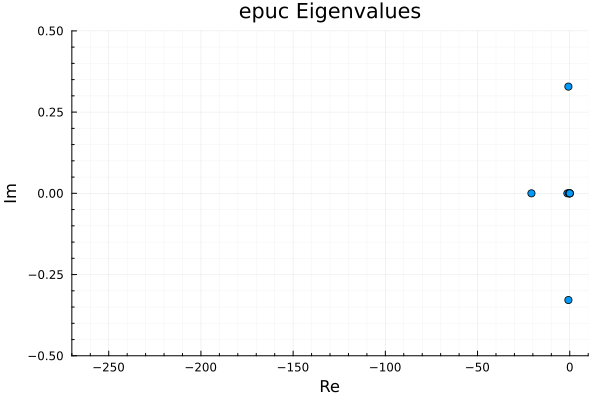

In [83]:
p_epuc_poles = plot()
# for i in 1:10
#     foo = eigen(op_epuc[i].A)
#     plot!(p_epuc_poles, real(foo.values), imag(foo.values), seriestype=:scatter, label="r = $i")
# end
foo = eigen(op_epuc.A)
plot!(p_epuc_poles, real(foo.values), imag(foo.values), seriestype=:scatter)
plot!(p_epuc_poles, xlabel="Re", ylabel="Im", legend=false, title="epuc Eigenvalues")
plot!(p_epuc_poles, majorgrid=true, minorgrid=true, size=(600, 400))
plot!(p_epuc_poles, xlims=(-270, 10), ylims=(-0.5, 0.5))

In [ ]:
p_epuc_poles = plot()
for i in 1:10
    foo = eigen(op_epuc[i].A)
    plot!(p_epuc_poles, real(foo.values), imag(foo.values), seriestype=:scatter, label="r = $i")
end
plot!(p_epuc_poles, xlabel="Re", ylabel="Im", legend=:right, title="epuc Eigenvalues")
plot!(p_epuc_poles, majorgrid=true, minorgrid=true, size=(600, 400))
plot!(p_epuc_poles, xlims=(-5,5), ylims=(-0.5, 0.5))

In [45]:
for i in 1:10
    foo = eigen(op_epuc[i].A)
    println("Eigenvalues of A for r = $i is: ", foo.values)
end

Eigenvalues of A for r = 1 is: [-5.985254803123995]
Eigenvalues of A for r = 2 is: [-24.53137694531067, -5.920118619096378]
Eigenvalues of A for r = 3 is: [-54.47395450579473, -23.675439710298328, -5.919542147915124]
Eigenvalues of A for r = 4 is: [-53.255369995686394, -23.684955838933597, -5.9193602331008845, -5.654591274837659]
Eigenvalues of A for r = 5 is: [-52.88222883767128, -23.68569525744928, -7.660922139287116, -5.919238607420506, -1.417660710201768]
Eigenvalues of A for r = 6 is: [-52.84970744149332, -23.68859225655263, -7.792550422888814, -5.919116721360958, -1.5959334892436905, -0.013455201486503797]
Eigenvalues of A for r = 7 is: [-52.75791763322108, -23.694484545178565, -8.539629435555174, -5.9191297173054584, -2.034827040056785, -0.04853068789216789, -1.2489160333126569e-5]
Eigenvalues of A for r = 8 is: [-52.75791778962535, -23.69448452533883, -8.539630516372592, -5.919129728885955, -2.03482791138081, -0.04853073429843545, -1.248916683125798e-5, -4.199186853772944e-13]


In [17]:
foo = norm(op_int.A - op_ephec[10].A, 2)
bar = norm(op_int.A - op_epsic[10].A, 2)
pac = norm(op_int.A - op_epuc[10].A, 2)
zux = norm(op_int.A - op_LS.A, 2)
println("EPHEC = $foo")
println("EPSIC = $bar")
println("EPUC = $pac")
println("LS = $zux")

EPHEC = 211182.18428743008
EPSIC = 953.2109910657733
EPUC = 957.9575645093631
LS = 950.1306727989041


In [19]:
foo = norm(op_int.F - op_ephec[10].F, 2)
bar = norm(op_int.F - op_epsic[10].F, 2)
pac = norm(op_int.F - op_epuc[10].F, 2)
zux = norm(op_int.F - op_LS.F, 2)
println("EPHEC = $foo")
println("EPSIC = $bar")
println("EPUC = $pac")
println("LS = $zux")

EPHEC = 222.19899056477226
EPSIC = 120.98291535882657
EPUC = 39.63744604208928
LS = 42.93754315139381


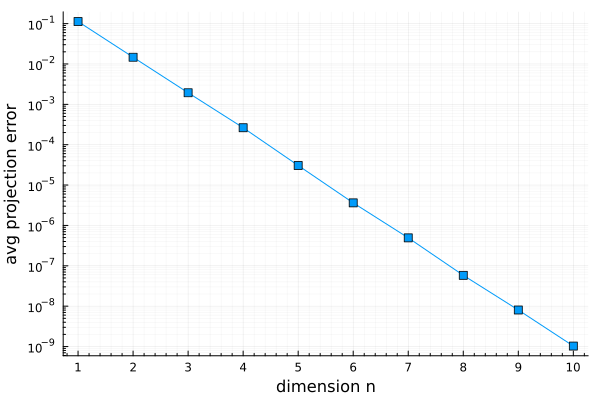

In [11]:
# Projection error
plot(rmin:rmax, proj_err, marker=(:rect))
plot!(yscale=:log10, majorgrid=true, minorgrid=true, legend=false)
tmp = log10.(proj_err)
yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+1])
xticks!(rmin:rmax)
xlabel!("dimension n")
ylabel!("avg projection error")

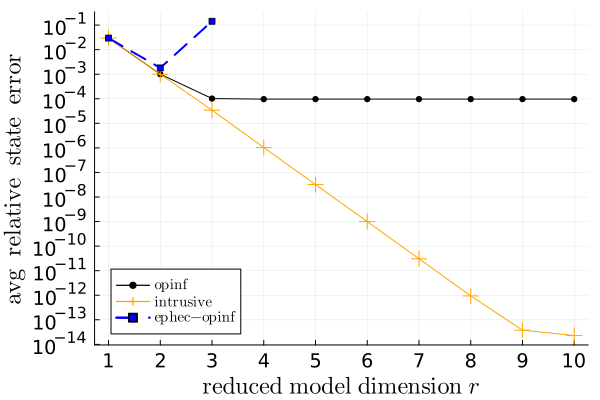

In [13]:
# State errors
plot(rmin:rmax, ls_state_err, c=:black, marker=(:circle, 3.5), label=L"\mathrm{opinf}")
plot!(rmin:rmax, intru_state_err, c=:orange, marker=(:cross, 8), label=L"\mathrm{intrusive}")
plot!(rmin:rmax, ephec_state_err, c=:blue, marker=(:rect, 3), ls=:dash, lw=2, label=L"\mathrm{ephec}\rm{-}\mathrm{opinf}")
# plot!(rmin:rmax, epsic_state_err, marker=(:dtriangle, 5), ls=:dot, label=L"\mathrm{epsic}\rm{-}\mathrm{opinf}")
# plot!(rmin:rmax, epuc_state_err, c=:red, marker=(:star, 3), ls=:dash, lw=1, label=L"\mathrm{epuc}\rm{-}\mathrm{opinf}")
plot!(yscale=:log10, majorgrid=true, legend=:bottomleft)
tmp = log10.(intru_state_err)
yticks!([10.0^i for i in floor(minimum(tmp))-1:ceil(maximum(tmp))+3])
# yticks!(10.0 .^(-8:1:1))
xticks!(rmin:rmax)
xlabel!(L"\mathrm{reduced~model~dimension~} r")
ylabel!(L"\mathrm{avg~~relative~~state~~error}")
plot!(guidefontsize=16, tickfontsize=13,  legendfontsize=10, legend=:bottomleft)

In [11]:
ephec_state_err

10-element Vector{Float64}:
   0.029700950258423998
   0.0009998845015907075
   0.00010171607110584101
   8.622970812705012e-5
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

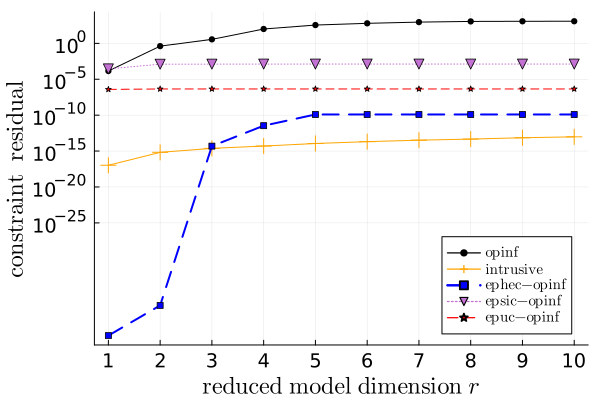

In [16]:
# Constraint residuals
plot(rmin:rmax, ls_cr, marker=(:circle, 3.5), c=:black, label=L"\mathrm{opinf}")
plot!(rmin:rmax, intru_cr, c=:orange, marker=(:cross, 8), label=L"\mathrm{intrusive}")
plot!(rmin:rmax, ephec_cr, c=:blue, marker=(:rect, 3), lw=2, ls=:dash, label=L"\mathrm{ephec}\rm{-}\mathrm{opinf}")
plot!(rmin:rmax, epsic_cr, marker=(:dtriangle, 5), ls=:dot, label=L"\mathrm{epsic}\rm{-}\mathrm{opinf}")
plot!(rmin:rmax, epuc_cr, c=:red, marker=(:star, 3), lw=1, ls=:dash, label=L"\mathrm{epuc}\rm{-}\mathrm{opinf}")
plot!(yscale=:log10, majorgrid=true, legend=:bottomright, minorgridalpha=0.03)
yticks!(10.0 .^ [-25, -20, -15, -10, -5, 0, 5])
xticks!(rmin:rmax)
xlabel!(L"\mathrm{reduced~model~dimension}~r")
ylabel!(L"\mathrm{constraint~~residual}")
plot!(guidefontsize=16, tickfontsize=13,  legendfontsize=10)